In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

%matplotlib inline

from pydrake.all import (SignalLogger, CompliantMaterial, ConstantVectorSource, DirectCollocation, DiagramBuilder, FloatingBaseType,
                         PiecewisePolynomial, RigidBodyTree, RigidBodyPlant,
                         SolutionResult, AddModelInstancesFromSdfString,
                         MathematicalProgram, Simulator, BasicVector, AddFlatTerrainToWorld)
from underactuated import (FindResource, PlanarRigidBodyVisualizer)

In [6]:
# set the initial state

x = 2
z = np.sqrt(2)

x_dot = 0.0
z_dot = 0.0

thetay = 0.0

# state of the flywheel
phi = 0.0
phi_dot = 0.0

torque = -0.0

# time of simulation (number of seconds)
time_of_sim = 2.0


state_initial = (x,0.,z,0.,thetay,0.,phi,x_dot,0.,z_dot,0.,0.,0.,phi_dot)

Num states: 14


/home/luke/.local/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Spawning PlanarRigidBodyVisualizer for tree with 1 actuators


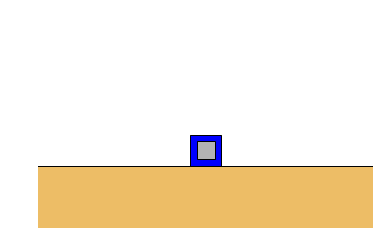

In [7]:
timestep = 0.0
builder = DiagramBuilder()
tree = RigidBodyTree(FindResource("cubli/cubli.urdf"),
                     FloatingBaseType.kFixed)
plant = RigidBodyPlant(tree, timestep)
nx = tree.get_num_positions() + tree.get_num_velocities()
print("Num states: {}".format(nx))

allmaterials = CompliantMaterial()
allmaterials.set_youngs_modulus(1E9) # default 1E9
allmaterials.set_dissipation(1.0) # default 0.32
allmaterials.set_friction(1.0) # default 0.9.
plant.set_default_compliant_material(allmaterials)

plant_context = plant.CreateDefaultContext()

robot = builder.AddSystem(plant)

torque_system = builder.AddSystem(ConstantVectorSource(
    np.ones((tree.get_num_actuators(), 1))*torque))
builder.Connect(torque_system.get_output_port(0),
                robot.get_input_port(0))

# what do xlim and ylim mean, what about -5 for the ground element
vis = builder.AddSystem(PlanarRigidBodyVisualizer(tree, xlim=[-2.5, 2.5], ylim=[-1, 2.5]))
builder.Connect(robot.get_output_port(0),
                vis.get_input_port(0))

# And also log
signalLogRate = 60
signalLogger = builder.AddSystem(SignalLogger(nx))
signalLogger._DeclarePeriodicPublish(1. / signalLogRate, 0.0)
builder.Connect(robot.get_output_port(0),
                signalLogger.get_input_port(0))

diagram = builder.Build()

simulator = Simulator(diagram)
simulator.set_target_realtime_rate(0.25)
simulator.set_publish_every_time_step(False)

In [8]:
context = simulator.get_mutable_context()
state = context.get_mutable_state().get_mutable_continuous_state().get_mutable_vector()
state.SetFromVector(state_initial)
simulator.StepTo(time_of_sim)

In [9]:
ani = vis.animate(signalLogger, repeat=True)
HTML(ani.to_html5_video())

In [ ]:
def contact_check(state):
    return True

In [ ]:
def cube_guard(state):
    

In [310]:
def cube_contact(state, u):
    # Contact dynamics of cube
    
    # Need to grab important parameters
    M_c = 1.0 # self.M_c
    M_w = 1.0 # self.M_w
    M_t = M_c + M_w
    
    I_c = 1.0 #self.I_c
    I_w = 1.0 #self.I_w
    I_t = I_c + I_w
    
    # Distance from edge to center of cube
    L_t = np.sqrt(2) #np.sqrt.(2*self.L)  
    
    # Assuming friction is 0 right now
    F_c = 0.5
    F_w = 0.5
    
    g = 9.81 # self.g
    
    # Relevant states are x,z,thetay, phi
    x = state[0]
    z = state[2]
    thetay = state[4]
    phi = state[6]
    
    xdot = state[7]
    zdot = state[9]
    thetaydot = state[11]
    phidot = state[13]
    
    # Setup the derivative of the state vector
    derivs = np.zeros_like(state)
    derivs[0:7] = state[7:]
    
    # Cos issue taylor expansion
    cos_theta = 1 - thetay**2/2 + thetay**2/24
    
    # Dynamics while the block is on the ground
    # Right now, assumes enough friction in x direction to only rotate
    # Right now, assumes sticky ground so it only rotates.
    derivs[7] = 0.0 # Force balance in x, friction etc.  
    derivs[9] = 0.0 # Force balance in z, normal force 
    
    # Moment balance around center of block 
    derivs[11] = (L_t*M_t*g*cos_theta - u[0] + F_w*phidot - F_c*thetaydot)/I_c 
    
    # Torque on the inertia wheel
    derivs[13] = (-L_t*M_t*g*cos_theta + u[0]*I_t + F_c*thetaydot*I_w - F_w*phidot*I_t)/(I_w*I_c)

    return derivs

In [293]:
def cube_ballistic(state, u):
    # Ballistic Dynamics of the cube
    
    # Need to grab important parameters
    M_c = 1.0 # self.M_c
    M_w = 1.0 # self.M_w
    M_t = M_c + M_w
    
    I_c = 1.0 #self.I_c
    I_w = 1.0 #self.I_w
    I_t = I_c + I_w
    
    # Distance from edge to center of cube
    L_t = np.sqrt(2) #np.sqrt.(2*self.L)  
    
    # Assuming friction is 0 right now
    F_c = 0.5
    F_w = 0.5
    
    g = 9.81 # self.g
    
    # Relevant states are x,z,thetay, phi
    x = state[0]
    z = state[2]
    thetay = state[4]
    phi = state[6]
    
    # Velocity States
    xdot = state[7]
    zdot = state[9]
    thetaydot = state[11]
    phidot = state[13]
    
    # Setup the derivative of the state vector
    derivs = np.zeros_like(state)
    derivs[0:7] = state[7:]
    
    # Ballistic Dynamics
    derivs[7] = 0.0 # No forces along x
    derivs[9] = -g  # Acceleration due to gravity
    
    # Back torque due to wheel
    derivs[11] = (-u[0] + F_w*phidot + F_c*thetaydot)/I_c
#     derivs[11] = 0.0
    # Wheel accel
    derivs[13] = (u[0]*I_t + F_c*thetaydot*I_w - F_w*phidot*I_t)/(I_w*I_c)
#     derivs[13] = 0.0
    
    return derivs     

In [304]:
def compute_optimal_control(initial_state,final_state, min_time, max_time):
    # Setup solver
    mp = MathematicalProgram()

    # number knot points
    N = 50
    
    # Total time used
    time_used = mp.NewContinuousVariables(1, "time_used") # add random variabe for time used
    dt = time_used/(N+1)
    
    
    # Control decision variables
    u = mp.NewContinuousVariables(1, "u_%d" % 0) # only one input for the cube
    u_over_time = u
    for k in range(1,N):
        u = mp.NewContinuousVariables(1, "u_%d" % k)
        u_over_time = np.vstack((u_over_time, u))
    total_u = u_over_time

    # State decision variabless
    x = mp.NewContinuousVariables(14, "x_%d" % 0) # for both input thrusters
    x_over_time = x
    for k in range(1,N+1):
        x = mp.NewContinuousVariables(14, "x_%d" % k)
        x_over_time = np.vstack((x_over_time, x))
    total_x = x_over_time

    # State Constraints
    error_thresh = 0.001
    for n in range(N):
        # Actual state vs. predicted (through dynamics) state
        state_next = total_x[n+1]
        dynamic_state_next = total_x[n,:] + cube_contact(total_x[n,:], total_u[n,:])*dt
#         dynamic_state_next = total_x[n,:] + cube_ballistic(total_x[n,:], total_u[n,:])*dt
        
        # Make sure the actual and predicted align to follow dynamics
        for j in range(14):
            state_error = state_next[j] - dynamic_state_next[j]
            mp.AddConstraint(state_error <= error_thresh)
            mp.AddConstraint(state_error >= -error_thresh)

    # Quadratic Cost in control effort
    # TODO: Make this cost of transport, better measure of effort
    # COT = u^2/(m_tot*g*d)
    mp.AddQuadraticCost(1 * u_over_time[:,0].dot(u_over_time[:,0]))

    # Add initial state constraint
    for i in range(14):
        initial_state_error = x_over_time[0,i] - initial_state[i]
        mp.AddConstraint(initial_state_error == 0.0)
    
    # Add final state constraint
    # Let's us specify where we want the cube to be
#     for i in range(14):
#         state_error = x_over_time[-1,i] - final_state[i]    
#         mp.AddConstraint(state_error <= 1)
#         mp.AddConstraint(state_error >= -1)
#     # Position Constraint
    x_error = x_over_time[-1,0] - final_state[0]
    mp.AddConstraint(x_error <= error_thresh)
    mp.AddConstraint(x_error >= -error_thresh)
    
    z_error = x_over_time[-1,2] - final_state[2]
    mp.AddConstraint(z_error <= error_thresh)
    mp.AddConstraint(z_error >= -error_thresh)
    
    theta_error = x_over_time[-1,4] - final_state[4]
    mp.AddConstraint(theta_error <= error_thresh)
    mp.AddConstraint(theta_error >= -error_thresh)
    
    # add time constraint
    mp.AddConstraint(time_used[0] >= minimum_time)
#     mp.AddConstraint(time_used[0] <= maximum_time)

    print "Number of decision vars", mp.num_vars()
    print(mp.Solve())

    trajectory = mp.GetSolution(x_over_time)
    input_trajectory = mp.GetSolution(u_over_time)
    t = mp.GetSolution(time_used)
    time_array = np.arange(0.0, t, t/(N+1))
    
    
    
    return trajectory, input_trajectory, time_array

In [259]:
def plot_xz(trajectory):
    cube_x = trajectory[:,0] 
    cube_z = trajectory[:,2]
    
    fig, axes = plt.subplots(nrows=1,ncols=1)
    axes.plot(cube_x, cube_z)
#     axes.axis("equal")
    
    plt.show()

def plot_theta(trajectory, time_array):
    cube_theta = trajectory[:,4]
    print cube_theta.shape
    print time_array.shape
    fig, axes = plt.subplots(nrows=1, ncols=1)
    axes.plot(time_array, cube_theta)
#     axes.axis("equal")
    
    plt.show()
    
def plot_u(input_trajectory, time_array):
    fig, axes = plt.subplots(nrows=1,ncols=1)
    axes.plot(time_array, input_trajectory)
#     axes.axis("equal")
    
    plt.show()

In [316]:
# Set the inital condititions
x = 0.; z = 0.; thetay = 0.; phi = 0.; 
x_dot = 0.; z_dot = 0.; thetay_dot = 0.; phi_dot = 0.;

# Different starting places
origin_1 = (x,0.,z,0.,thetay,0.,phi,x_dot,0.,z_dot,0.,thetay_dot,0.,phi_dot)
# origin_2 = (0.,0.,50,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.)

# Set the desired final conditions
swing_up = (0.5,0.,np.sqrt(2)/2-0.5,0., np.pi/2,0.,phi,x_dot,0.,z_dot,0.,thetay_dot,0.,phi_dot)
# fall_down = (0.,0.,0.,0.,0.,0.0,0.,0.,0.,0.,0.,0.,0.,0.)

# Set the time constraints
minimum_time = 0.5; maximum_time = 15.

# Solve the trajectory optimization
traj, input_traj, time_array = compute_optimal_control(origin_1, swing_up, minimum_time, maximum_time)


Number of decision vars 765
SolutionResult.kSolutionFound


In [317]:
# Print trajectory information
print "Trajectory size: ", traj.shape
print "Input size: ", input_traj.shape
print "\n"

# Print initial conditions
print "Initial state: ", traj[0]
print "\n"

# Print final conditionsa
print "Final state: ", traj[-1]

print "Final time: ", time_array[-1]
print "Total energ: ", input_traj.dot(input_traj)

Trajectory size:  (51, 14)
Input size:  (50,)


Initial state:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


Final state:  [  4.99000000e-01   1.40000000e-02   2.06106781e-01   1.40000000e-02
   1.56979633e+00   1.40000000e-02   3.98526029e+01   5.00000000e-02
   1.00000000e-03   9.77376684e-04   1.00000000e-03   7.06150653e+00
   1.00000000e-03  -6.95083887e+00]
Final time:  18.3265306122
Total energ:  1661.41185598


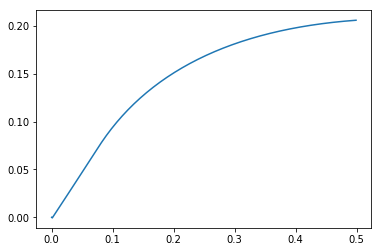

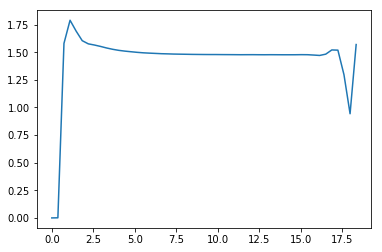

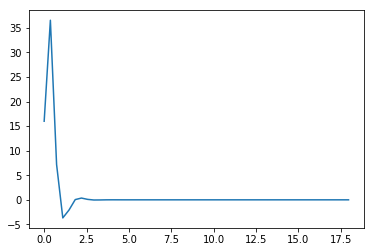

In [318]:
# Plot
plot_xz(traj)
plt.plot(time_array, traj[:,4])
plt.show()
plot_u(input_traj, time_array[:-1])